In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
gpd = pd.read_csv('data/gdp.csv', index_col='Year')
inflation = pd.read_csv('data/inflation.csv')
unemployment = pd.read_csv('data/unemployment.csv', index_col='date')
yield_data = pd.read_csv('data/yield.csv') #61

### Yield curves

In [19]:

# Convert to datetime
yield_data['Date'] = pd.to_datetime(yield_data['Date'], errors='coerce')

# Replace invalid values with NaN
yield_data.replace(-999.99, pd.NA, inplace=True)

# Drop columns with more than 20% missing values
threshold = 0.2 * len(yield_data)
columns_to_drop = yield_data.columns[yield_data.isnull().sum() > threshold]
yield_data_cleaned = yield_data.drop(columns=columns_to_drop)

# Rename columns 
column_rename_mapping = {
    'BETA0': 'LongTermRate',
    'BETA1': 'Slope',
    'BETA2': 'Curvature1',
    'BETA3': 'Curvature2',
}

for i in range(1, 31):
    column_rename_mapping[f'SVENPY{i:02d}'] = f'SpotRate{i}Y'


for i in range(1, 31):
    column_rename_mapping[f'SVEN1F{i:02d}'] = f'ForwardRate{i}Y'

yield_data_cleaned.rename(columns=column_rename_mapping, inplace=True)

# Drop rows where 'Date' or key features are missing
key_features = ['Date', 'LongTermRate', 'ForwardRate1Y']
yield_data_cleaned = yield_data_cleaned.dropna(subset=key_features)

# Set Date as the index for resampling
yield_data_cleaned.set_index('Date', inplace=True)

# Resample to monthly frequency
monthly_data = yield_data_cleaned.resample('M').mean()

# Interpolate missing values for continuous features
monthly_data_interpolated = monthly_data.interpolate(method='linear', limit_direction='forward', axis=0)

# Logarithmic transformation to reduce skewness for curvature columns
curvature_columns = ['Curvature1', 'Curvature2']
for column in curvature_columns:
    monthly_data_interpolated[column] = monthly_data_interpolated[column].apply(
        lambda x: np.log1p(x) if x > 0 else 0
    )

# Normalize continuous features to the range [0, 1]
continuous_features = [
    col for col in monthly_data_interpolated.columns if col.startswith('LongTermRate') or col.startswith('Slope')
    or col.startswith('Curvature') or col.startswith('SpotRate') or col.startswith('ForwardRate')
]
monthly_data_interpolated[continuous_features] = monthly_data_interpolated[continuous_features].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=0
)

# Final Output: Display the first few rows of the processed dataset
print(monthly_data_interpolated.head())




            LongTermRate     Slope  Curvature1  Curvature2  SVEN1F01  \
Date                                                                   
1961-06-30      0.160110  0.463769    0.000000         0.0  0.233760   
1961-07-31      0.164034  0.446137    0.000000         0.0  0.230211   
1961-08-31      0.169935  0.452569    0.000000         0.0  0.236753   
1961-09-30      0.165211  0.453090    0.000000         0.0  0.237257   
1961-10-31      0.152620  0.455216    0.113939         0.0  0.230314   

            SVEN1F04  SVEN1F09   SVENF01   SVENF02   SVENF03  ...   SVENY02  \
Date                                                          ...             
1961-06-30  0.247301       NaN  0.221101  0.255323  0.261874  ...  0.211179   
1961-07-31  0.254123       NaN  0.214934  0.255350  0.266802  ...  0.205111   
1961-08-31  0.264753       NaN  0.220417  0.263449  0.276710  ...  0.213567   
1961-09-30  0.256468       NaN  0.224142  0.260710  0.270093  ...  0.215156   
1961-10-31  0.247019 

C:\Users\devpa\AppData\Local\Temp\ipykernel_37128\560105885.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = yield_data_cleaned.resample('M').mean()


### Unemployment

In [ ]:
# code

### Inflation

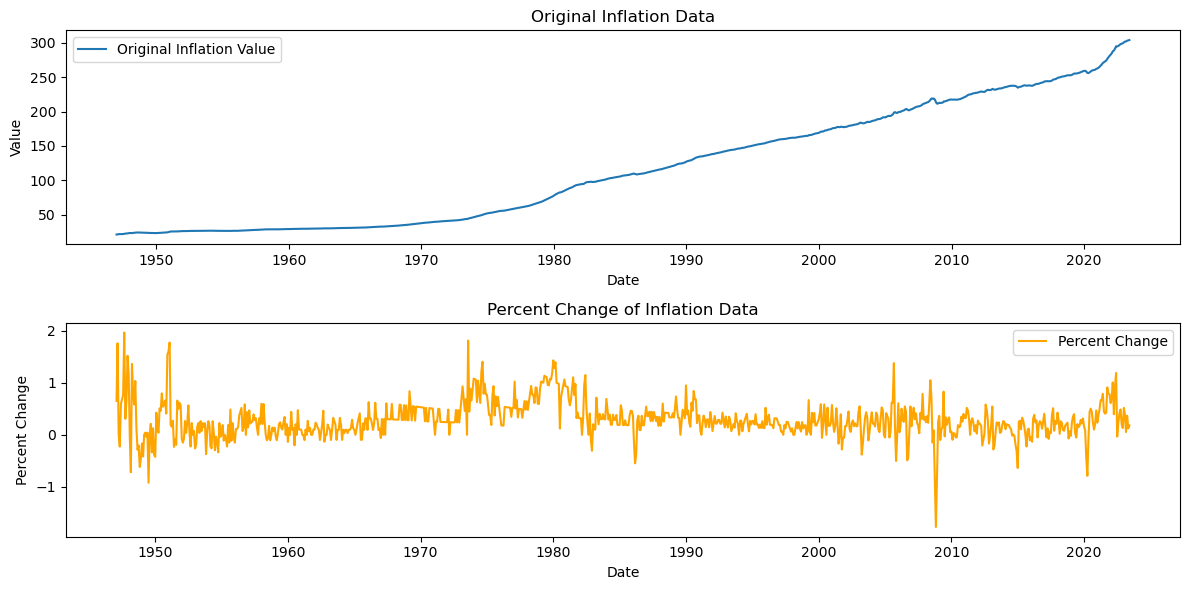

In [7]:
inflation['date'] = pd.to_datetime(inflation['date'])

# Calculate the percent change
inflation['percent_change'] = inflation['value'].pct_change() * 100

# Plot the original and percent change data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(inflation['date'], inflation['value'], label='Original Inflation Value')
plt.title('Original Inflation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(inflation['date'], inflation['percent_change'], label='Percent Change', color='orange')
plt.title('Percent Change of Inflation Data')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()

plt.tight_layout()
plt.show()